In [1]:
import json
import os

# Chemin vers le fichier
json_path = "../data/arc-agi_training_challenges.json"

# Chargement du fichier json
with open(json_path, 'r') as f:
    data = json.load(f)

# Affichage de la taille et de quelques exemples
print("Nombre d'exemples charg√©s :", len(data))

# Affichage d'un exemple au format brut
first_key = list(data.keys())[0]
print(f"\nExemple : {first_key}")
print(json.dumps(data[first_key], indent=2))

Nombre d'exemples charg√©s : 1000

Exemple : 00576224
{
  "train": [
    {
      "input": [
        [
          7,
          9
        ],
        [
          4,
          3
        ]
      ],
      "output": [
        [
          7,
          9,
          7,
          9,
          7,
          9
        ],
        [
          4,
          3,
          4,
          3,
          4,
          3
        ],
        [
          9,
          7,
          9,
          7,
          9,
          7
        ],
        [
          3,
          4,
          3,
          4,
          3,
          4
        ],
        [
          7,
          9,
          7,
          9,
          7,
          9
        ],
        [
          4,
          3,
          4,
          3,
          4,
          3
        ]
      ]
    },
    {
      "input": [
        [
          8,
          6
        ],
        [
          6,
          4
        ]
      ],
      "output": [
        [
          8,
          6,
          8

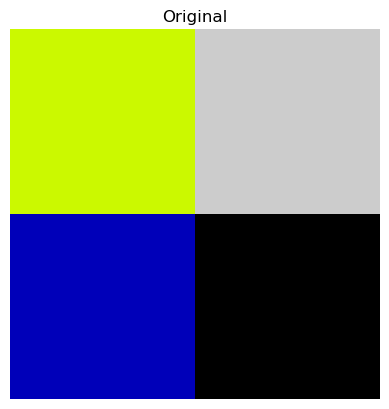

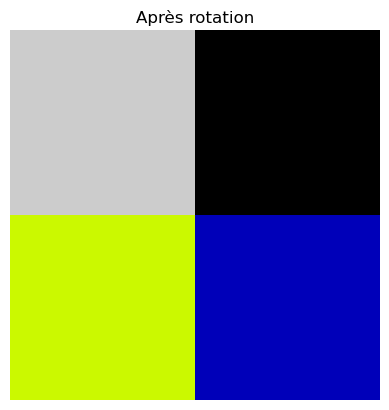

In [2]:
import sys
sys.path.append("..") # Pour acc√©der aux fichiers du dossier parent

from primitives.transformations import rotate_grid, transpose_grid, flip_grid, recolor_grid

from matplotlib import pyplot as plt
import numpy as np

def plot_grid(grid, title=""):
    plt.imshow(grid, cmap="nipy_spectral", interpolation="nearest")
    plt.title(title)
    plt.axis("off")
    plt.show()

# Choix du mod√®le
example_id = "00576224"
example = data[example_id]["train"][0]["input"]

# Transformation
rotated = rotate_grid(example)

# Affichage original + transform√©
plot_grid(np.array(example), "Original")
plot_grid(np.array(rotated), "Apr√®s rotation")

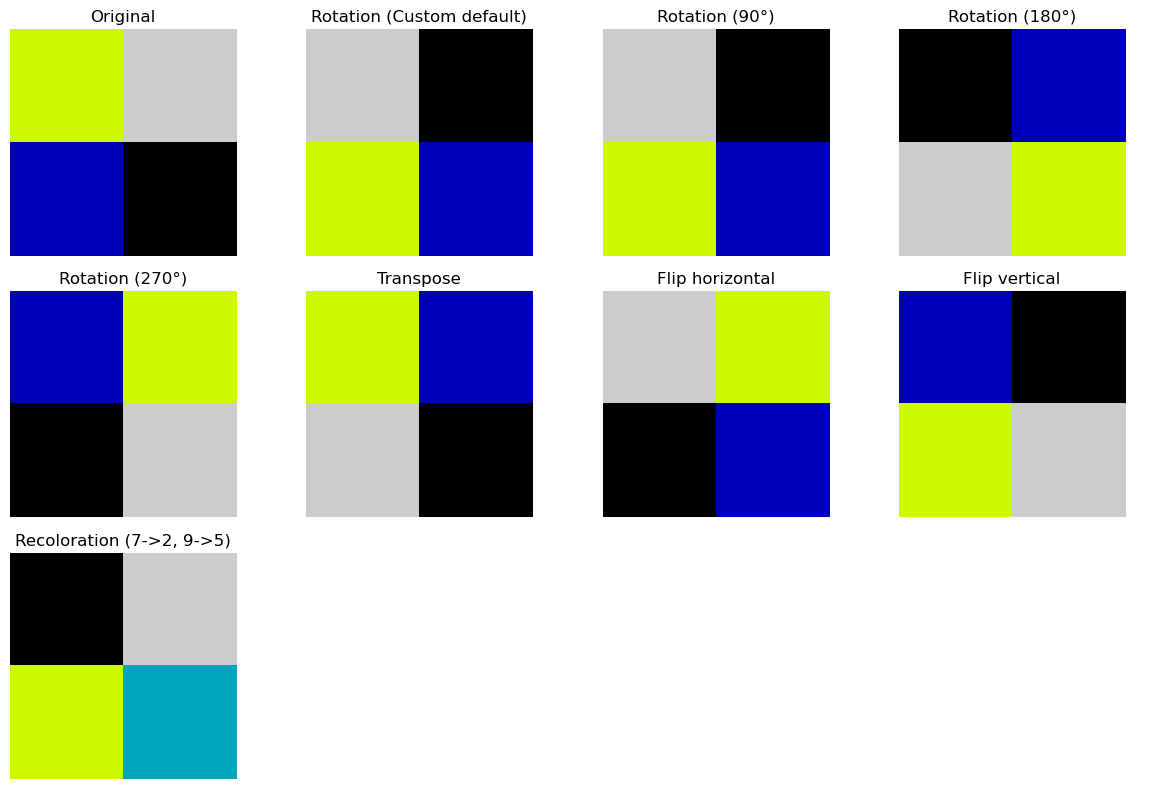

In [3]:
def plot_grids(grids, titles, ncols=4, figsize=(12, 8)):
    nrows = int(np.ceil(len(grids) / ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    axs = axs.flatten()
    for i, (grid, title) in enumerate(zip(grids, titles)):
        axs[i].imshow(grid, cmap='nipy_spectral', interpolation='nearest')
        axs[i].set_title(title)
        axs[i].axis('off')
    for i in range(i+1, len(axs)):
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

# Exemple de grille
example_id = "00576224"
example = data[example_id]["train"][0]["input"]
example_array = np.array(example)

# Toutes les transformations de base
grids = [
    example_array,
    np.array(rotate_grid(example)),
    np.array(rotate_grid(example, 90)),
    np.array(rotate_grid(example, 180)),
    np.array(rotate_grid(example, 270)),
    np.array(transpose_grid(example)),
    np.array(flip_grid(example, 'horizontal')),
    np.array(flip_grid(example, 'vertical')),
    np.array(recolor_grid(example, {7: 2, 9: 5})), # recoloration d'exemple
]

titles = [
    "Original",
    "Rotation (Custom default)",
    "Rotation (90¬∞)",
    "Rotation (180¬∞)",
    "Rotation (270¬∞)",
    "Transpose",
    "Flip horizontal",
    "Flip vertical",
    "Recoloration (7->2, 9->5)",
]

# Affichage
plot_grids(grids, titles)

In [4]:
def apply_combination(grid, transpose=False, flip=None, rotate=0):
    result = grid
    if transpose:
        result = transpose_grid(result)
    if flip is not None:
        result = flip_grid(result, flip)
    if rotate != 0:
        result = rotate_grid(result, rotate)
    return result

def infer_transformation(input_grid, output_grid):
    from itertools import product
    rotations = [0, 90, 180, 270]
    flips = [None, "horizontal", "vertical"]
    transpositions = [False, True]

    for transpose, flip, rotate in product(transpositions, flips, rotations):
        transformed = apply_combination(input_grid, transpose, flip, rotate)
        if np.array_equal(transformed, output_grid):
            return {
                "transpose": transpose,
                "flip": flip,
                "rotate": rotate
            }
    return None

In [5]:
sample = data["017c7c7b"]["train"][0]
result = infer_transformation(np.array(sample["input"]), np.array(sample["output"]))
print("Transformation identifi√©e :", result)

Transformation identifi√©e : None


In [6]:
def display_transformation_analysis(example_id, data):
    """
    Affiche l'input et l'output pour un exemple donn√©.
    """
    example = data[example_id]["train"][0]
    input_grid = np.array(example["input"])
    output_grid = np.array(example["output"])

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    axes[0].imshow(input_grid, cmap="nipy_spectral", interpolation="nearest")
    axes[0].set_title("Input")
    axes[0].axis("off")

    axes[1].imshow(output_grid, cmap="nipy_spectral", interpolation="nearest")
    axes[1].set_title("Output")
    axes[1].axis("off")

    plt.suptitle(f"Task ID : {example_id}", fontsize=14)
    plt.tight_layout()
    plt.show()

    print(f"Dimensions : input = {input_grid.shape}, output = {output_grid.shape}")
    unique_input = np.unique(input_grid)
    unique_output = np.unique(output_grid)
    print(f"Couleurs input  : {unique_input}")
    print(f"Couleurs output : {unique_output}")

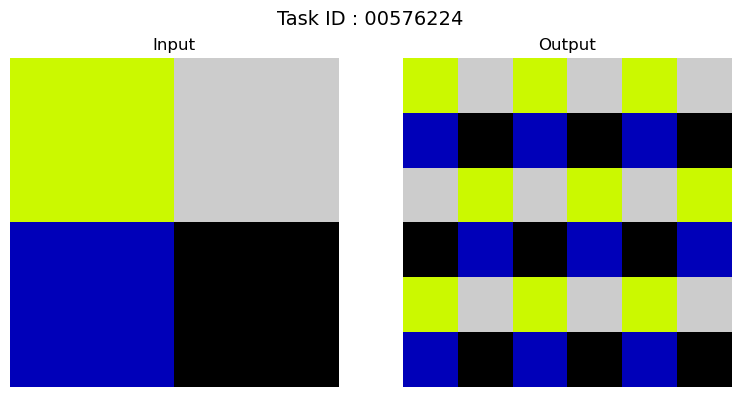

Dimensions : input = (2, 2), output = (6, 6)
Couleurs input  : [3 4 7 9]
Couleurs output : [3 4 7 9]


In [7]:
display_transformation_analysis("00576224", data)

In [8]:
def tile_grid(grid, times=3):
    """
    R√©p√®te une grille de base de fa√ßon tuile (tiling) en rows et colonnes.
    
    Args:
        grid (list of lists or np.ndarray): la grille de base √† r√©p√©ter.
        times (int): nombre de r√©p√©titions sur les axes (par d√©faut 3).
    
    Returns:
        np.ndarray: grille r√©p√©t√©e (tiled).
    """
    grid = np.array(grid)
    return np.tile(grid, (times, times))

In [9]:
def is_tiled_replication(input_grid, output_grid):
    """
    V√©rifie si l'output est une r√©p√©tition de l'input (pattern tiling).
    
    Args:
        input_grid (list or np.ndarray): grille d'entr√©e.
        output_grid (list or np.ndarray): grille de sortie.

    Returns:
        bool, int: True et facteur de r√©p√©tition si c‚Äôest une tiling r√©guli√®re, sinon False, None.
    """
    input_grid = np.array(input_grid)
    output_grid = np.array(output_grid)

    h_in, w_in = input_grid.shape
    h_out, w_out = output_grid.shape

    # V√©rifie que l'output est un multiple exact de l'input
    if h_out % h_in != 0 or w_out % w_in != 0:
        return False, None

    k_h = h_out // h_in
    k_w = w_out // w_in

    # On v√©rifie que tous les blocs r√©p√©t√©s sont identiques √† la grille d'origine
    tiled = np.tile(input_grid, (k_h, k_w))
    return np.array_equal(tiled, output_grid), k_h  # ou k_w (ils sont √©gaux ici)


In [10]:
example_id = "00576224"
example = data[example_id]["train"][0]

input_grid = example["input"]
output_grid = example["output"]

is_tiled, k = is_tiled_replication(input_grid, output_grid)

if is_tiled:
    print(f"Grille output = {k}x r√©plication de la grille input")
    tiled_grid = tile_grid(input_grid, times=k)
    assert np.array_equal(np.array(tiled_grid), np.array(output_grid))
else:
    print("Ce n'est pas une r√©p√©tition r√©guli√®re")


Ce n'est pas une r√©p√©tition r√©guli√®re


In [11]:
def detect_transformations(input_grid, output_grid):
    input_arr = np.array(input_grid)
    output_arr = np.array(output_grid)

    info = {
        "shape_change": input_arr.shape != output_arr.shape,
        "recoloration": False,
        "geometric_transform": None,
        "repetition": False, 
    }

    # Test recoloration
    unique_input = set(np.unique(input_arr))
    unique_output = set(np.unique(output_arr))
    if unique_input != unique_output and unique_input.issubset(unique_output):
        info["recoloration"] = True

    # Test geometric transformations
    if input_arr.shape == output_arr.shape:
        if np.array_equal(np.rot90(input_arr, 1), output_arr):
            info["geometric_transform"] = "rotate_90"
        elif np.array_equal(np.rot90(input_arr, 2), output_arr):
            info["geometric_transform"] = "rotate_180"
        elif np.array_equal(np.rot90(input_arr, 3), output_arr):
            info["geometric_transform"] = "rotate_270"
        elif np.array_equal(np.flipud(input_arr), output_arr):
            info["geometric_transform"] = "flip_vertical"
        elif np.array_equal(np.fliplr(input_arr), output_arr):
            info["geometric_transform"] = "flip_horizontal"

    # Test repetition
    if (output_arr.shape[0] % input_arr.shape[0] == 0 and
        output_arr.shape[1] % input_arr.shape[1] == 0):
        tile = np.tile(input_arr, (output_arr.shape[0] // input_arr.shape[0],
                                     output_arr.shape[1] // input_arr.shape[1]))
        if np.array_equal(tile, output_arr):
            info["repetition"] = True

    return info

In [12]:
import pandas as pd
from tqdm import tqdm

results = []

for task_id, task_data, in tqdm(data.items(), desc='Analyse des t√¢ches'):
    input_grid = task_data["train"][0]["input"]
    output_grid = task_data["train"][0]["output"]

    transformation_info = detect_transformations(input_grid, output_grid)
    transformation_info["task_id"] = task_id

    results.append(transformation_info)

df_results = pd.DataFrame(results)

Analyse des t√¢ches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1000/1000 [00:00<00:00, 10009.36it/s]


In [13]:
df_results.to_json("../data/detected_transformations.json", orient="records", indent=2)

In [14]:
sys.path.append("..")

from analysis.detectors import detect_transformations

# Appel de la fonction
transformation_info = detect_transformations(input_grid, output_grid)

# Affichage des r√©sultats
print("R√©sultat de la d√©tection :")
for key, value in transformation_info.items():
    print(f"{key}: {value}")

R√©sultat de la d√©tection :
input_shape: (24, 24)
output_shape: (5, 5)
input_colors: [0, 1, 3, 6, 8]
output_colors: [0, 6]
recoloration: True
rotation_90: False
rotation_180: False
rotation_270: False
flip_horizontal: False
flip_vertical: False
transpose: False
repetition: False
padding: False
translation: False
tiled_subgrid: False
partial_symetry: None
pattern_checkerboard: False
pattern_horizontal_stripes: False
pattern_vertical_stripes: False
pattern_uniform_blocks: False
shape_based_recoloration: False


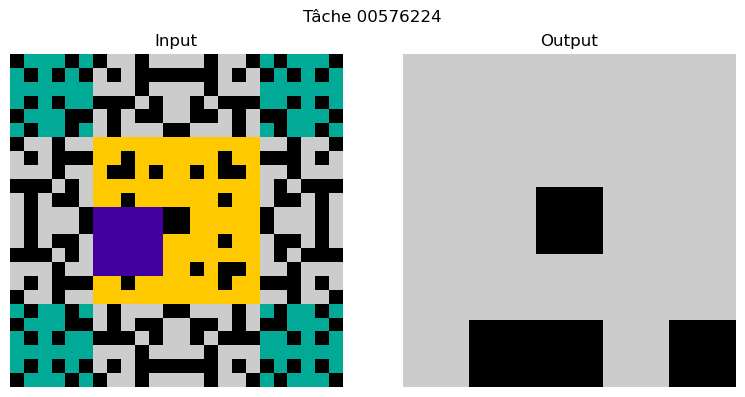

In [15]:
def plot_input_output(input_grid, output_grid, title="Comparaison"):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    axs[0].imshow(input_grid, cmap='nipy_spectral', interpolation='nearest')
    axs[0].set_title('Input')
    axs[0].axis('off')

    axs[1].imshow(output_grid, cmap='nipy_spectral', interpolation='nearest')
    axs[1].set_title('Output')
    axs[1].axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Sur l'exemple
plot_input_output(input_grid, output_grid, title=f"T√¢che {example_id}")

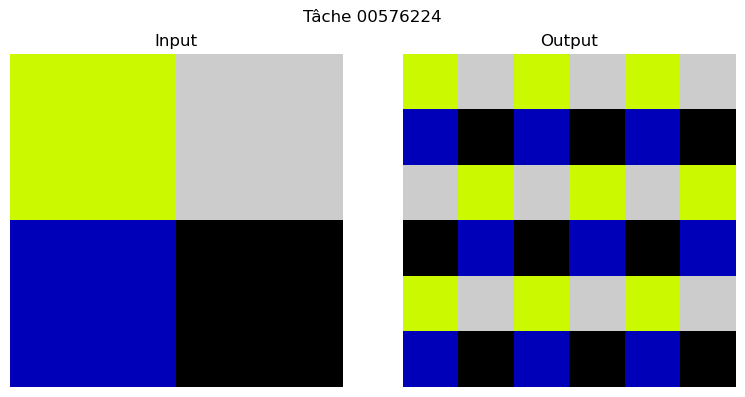

D√©tections pour la t√¢che 00576224 :
input_shape: (2, 2)
output_shape: (6, 6)
input_colors: [3, 4, 7, 9]
output_colors: [3, 4, 7, 9]
recoloration: False
rotation_90: False
rotation_180: False
rotation_270: False
flip_horizontal: False
flip_vertical: False
transpose: False
repetition: False
padding: True
translation: True
tiled_subgrid: False
partial_symetry: None
pattern_checkerboard: False
pattern_horizontal_stripes: True
pattern_vertical_stripes: True
pattern_uniform_blocks: False
shape_based_recoloration: False


In [16]:
# Reprise de l'ID exemple
example_id = "00576224"
task_data = data[example_id]

# Extraction des grilles
input_grid = np.array(task_data["train"][0]["input"])
output_grid = np.array(task_data["train"][0]["output"])

plot_input_output(input_grid, output_grid, title=f"T√¢che {example_id}")

transformation_info = detect_transformations(input_grid.tolist(), output_grid.tolist())

# Affichage des r√©sultats
print(f"D√©tections pour la t√¢che {example_id} :")
for k, v in transformation_info.items():
    print(f"{k}: {v}")

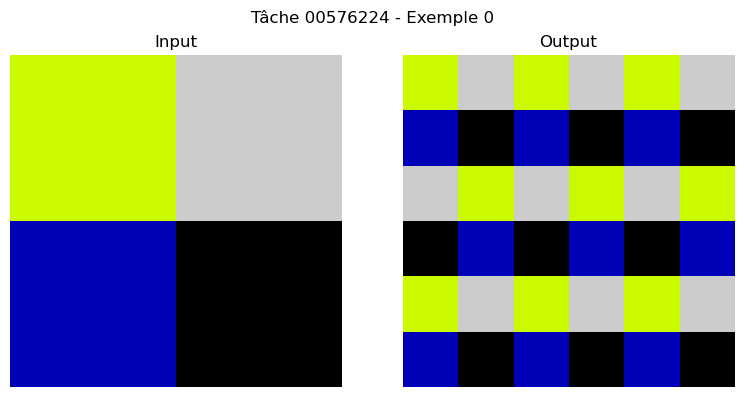

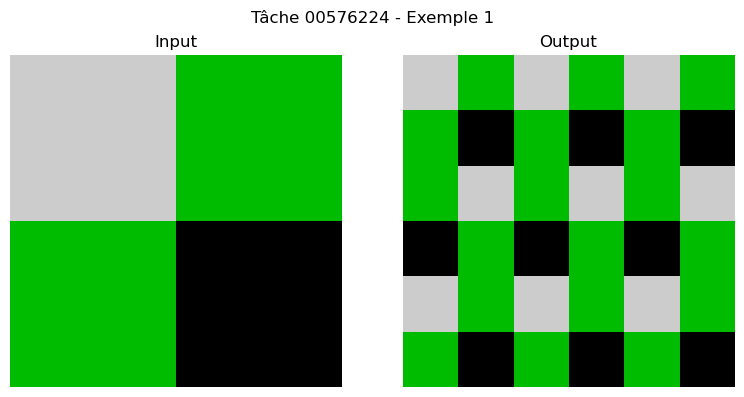

In [17]:
def plot_all_examples(task_data, task_id):
    train_pairs = task_data["train"]
    for i, pair in enumerate(train_pairs):
        input_grid = np.array(pair["input"])
        output_grid = np.array(pair["output"])
        title = f"T√¢che {task_id} - Exemple {i}"
        plot_input_output(input_grid, output_grid, title=title)

# Exemple : toutes les entr√©es pour la t√¢che 00576224
task_id = "00576224"
plot_all_examples(data[task_id], task_id)

--- Analyse de l'exemple 0 (t√¢che 00576224) ---


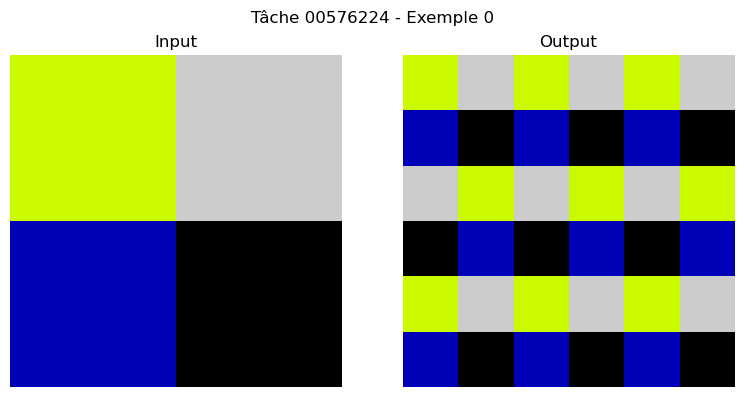

Transformation input_shape: (2, 2)
Transformation output_shape: (6, 6)
Transformation input_colors: [3, 4, 7, 9]
Transformation output_colors: [3, 4, 7, 9]
Transformation recoloration: False
Transformation rotation_90: False
Transformation rotation_180: False
Transformation rotation_270: False
Transformation flip_horizontal: False
Transformation flip_vertical: False
Transformation transpose: False
Transformation repetition: False
Transformation padding: True
Transformation translation: True
Transformation tiled_subgrid: False
Transformation partial_symetry: None
Transformation pattern_checkerboard: False
Transformation pattern_horizontal_stripes: True
Transformation pattern_vertical_stripes: True
Transformation pattern_uniform_blocks: False
Transformation shape_based_recoloration: False


--- Analyse de l'exemple 1 (t√¢che 00576224) ---


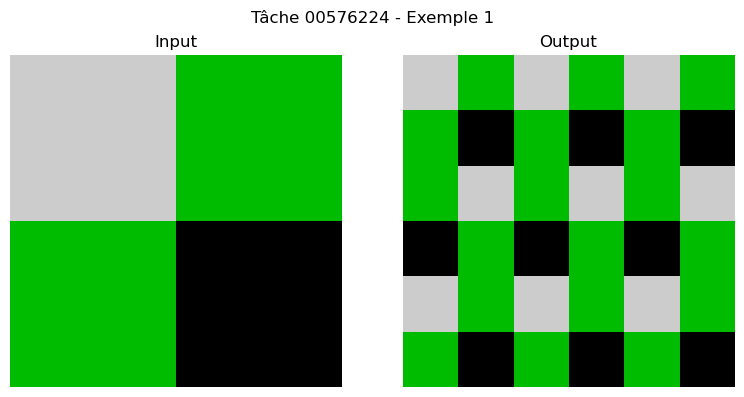

Transformation input_shape: (2, 2)
Transformation output_shape: (6, 6)
Transformation input_colors: [4, 6, 8]
Transformation output_colors: [4, 6, 8]
Transformation recoloration: False
Transformation rotation_90: False
Transformation rotation_180: False
Transformation rotation_270: False
Transformation flip_horizontal: False
Transformation flip_vertical: False
Transformation transpose: False
Transformation repetition: False
Transformation padding: True
Transformation translation: True
Transformation tiled_subgrid: False
Transformation partial_symetry: None
Transformation pattern_checkerboard: False
Transformation pattern_horizontal_stripes: True
Transformation pattern_vertical_stripes: True
Transformation pattern_uniform_blocks: False
Transformation shape_based_recoloration: False




In [18]:
def analyze_all_examples(task_id, task_data):
    for i, pair in enumerate(task_data["train"]):
        input_grid = pair["input"]
        output_grid = pair["output"]

        print(f"--- Analyse de l'exemple {i} (t√¢che {task_id}) ---")
        plot_input_output(input_grid, output_grid, title=f"T√¢che {task_id} - Exemple {i}")

        transformation_info = detect_transformations(input_grid, output_grid)
        for k, v in transformation_info.items():
            print(f"Transformation {k}: {v}")
        print("\n")

# Appel pour la t√¢che 00576224
analyze_all_examples("00576224", data["00576224"])

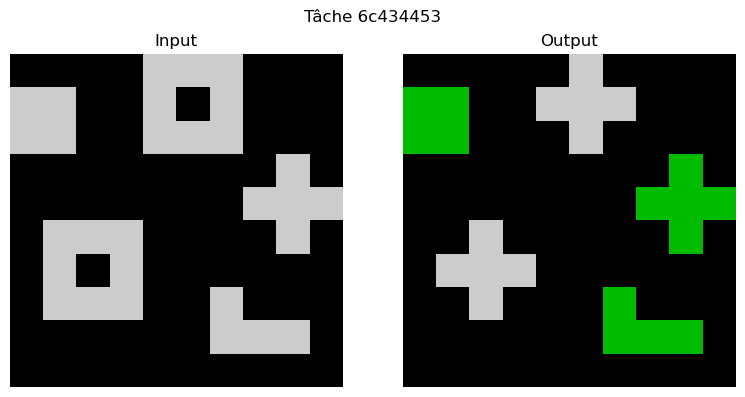

üîç Analyse des transformations d√©tect√©es pour la t√¢che 6c434453:

flip_horizontal               : False
flip_vertical                 : False
input_colors                  : [0, 1]
input_shape                   : (10, 10)
output_colors                 : [0, 1, 2]
output_shape                  : (10, 10)
padding                       : False
partial_symetry               : None
pattern_checkerboard          : False
pattern_horizontal_stripes    : False
pattern_uniform_blocks        : False
pattern_vertical_stripes      : False
recoloration                  : True
repetition                    : False
rotation_180                  : False
rotation_270                  : False
rotation_90                   : False
shape_based_recoloration      : True
tiled_subgrid                 : False
translation                   : False
transpose                     : False


In [19]:
from data.arc_utils import load_arc_file

data = load_arc_file("../data/arc-agi_training_challenges.json")

# Exemple √† tester
example_id = "6c434453"  # <- √† changer si on veut tester un autre exemple
task = data[example_id]
input_grid = task["train"][0]["input"]
output_grid = task["train"][0]["output"]

# D√©tection des transformations (y compris patterns)
transformation_info = detect_transformations(input_grid, output_grid)

# Affichage visuel
plot_input_output(input_grid, output_grid, title=f"T√¢che {example_id}")

# Affichage des r√©sultats (avec tri alphab√©tique pour lisibilit√©)
print(f"üîç Analyse des transformations d√©tect√©es pour la t√¢che {example_id}:\n")
for k, v in sorted(transformation_info.items()):
    print(f"{k:<30}: {v}")

Input Grid:


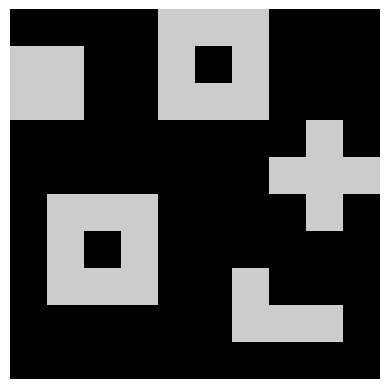

Output Grid:


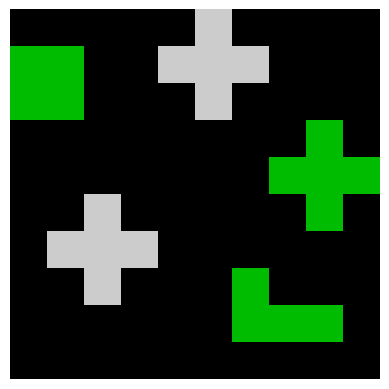


=== Analyse des transformations d√©tect√©es ===
input_shape                   : (10, 10)
output_shape                  : (10, 10)
input_colors                  : [0, 1]
output_colors                 : [0, 1, 2]
recoloration                  : True
rotation_90                   : False
rotation_180                  : False
rotation_270                  : False
flip_horizontal               : False
flip_vertical                 : False
transpose                     : False
repetition                    : False
padding                       : False
translation                   : False
tiled_subgrid                 : False
partial_symetry               : None
pattern_checkerboard          : False
pattern_horizontal_stripes    : False
pattern_vertical_stripes      : False
pattern_uniform_blocks        : False
shape_based_recoloration      : True


In [20]:
import json
from analysis.detectors import detect_transformations

# Chargement du fichier contenant toutes les t√¢ches
with open("../data/arc-agi_training_challenges.json", "r") as f:
    all_tasks = json.load(f)

task_id = "6c434453"
task_data = all_tasks[task_id]
input_grid = task_data["train"][0]["input"]
output_grid = task_data["train"][0]["output"]

# Affichage
print("Input Grid:")
plot_grid(input_grid)
print("Output Grid:")
plot_grid(output_grid)

# Analyse
result = detect_transformations(input_grid, output_grid)
print("\n=== Analyse des transformations d√©tect√©es ===")
for k, v in result.items():
    print(f"{k:<30}: {v}")


In [21]:
import importlib.util
spec = importlib.util.spec_from_file_location("detectors", "../analysis/detectors.py")
detectors = importlib.util.module_from_spec(spec)
spec.loader.exec_module(detectors)
detectors.detect_shape_based_recoloration(input_grid, output_grid)

True

In [22]:
TASKS_TO_TEST = [
    "6c434453",  # recoloration + forme conserv√©e (‚úÖ)
    "1b2d62fb",  # rotation + recoloration
    "b8825c91",  # recoloration partielle
    "b91ae062",  # flip vertical
    "f8b3ba0a",  # r√©p√©tition
    "ce22a75a",  # pas de transformation
]

def display_grids(input_grid, output_grid, task_id, example_id):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(input_grid, cmap="tab20", vmin=0)
    axs[0].set_title("Input")
    axs[1].imshow(output_grid, cmap="tab20", vmin=0)
    axs[1].set_title("Output")
    plt.suptitle(f"T√¢che {task_id} | Exemple {example_id}")
    plt.show()

def run_batch_tests(task_ids, example_id=0, json_path="../data/arc-agi_training_challenges.json"):
    data_all = load_arc_file(json_path)

    for task_id in task_ids:
        print(f"\n=== Analyse des transformations pour la t√¢che {task_id} ===")
        try:
            data = data_all[task_id]
            input_grid = data["train"][example_id]["input"]
            output_grid = data["train"][example_id]["output"]
            display_grids(input_grid, output_grid, task_id, example_id)
            result = detect_transformations(input_grid, output_grid)

            for k, v in result.items():
                print(f"{k:<30} : {v}")
        except Exception as e:
            print(f"‚ùå Erreur sur la t√¢che {task_id} : {e}")




=== Analyse des transformations pour la t√¢che 6c434453 ===


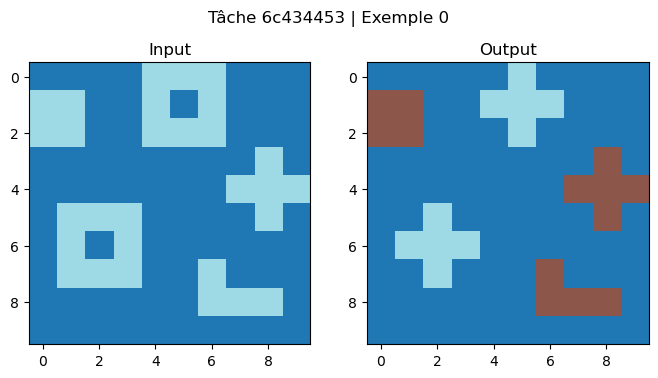

input_shape                    : (10, 10)
output_shape                   : (10, 10)
input_colors                   : [0, 1]
output_colors                  : [0, 1, 2]
recoloration                   : True
rotation_90                    : False
rotation_180                   : False
rotation_270                   : False
flip_horizontal                : False
flip_vertical                  : False
transpose                      : False
repetition                     : False
padding                        : False
translation                    : False
tiled_subgrid                  : False
partial_symetry                : None
pattern_checkerboard           : False
pattern_horizontal_stripes     : False
pattern_vertical_stripes       : False
pattern_uniform_blocks         : False
shape_based_recoloration       : True

=== Analyse des transformations pour la t√¢che 1b2d62fb ===


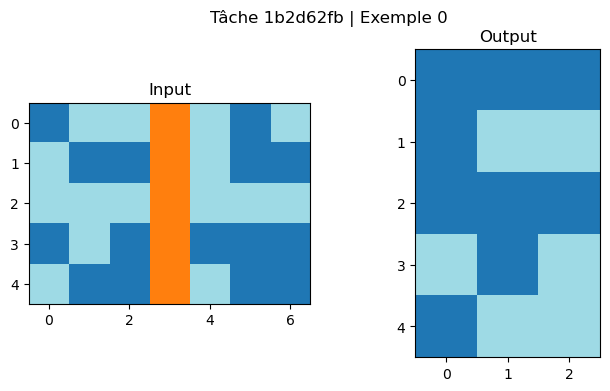

input_shape                    : (5, 7)
output_shape                   : (5, 3)
input_colors                   : [0, 1, 9]
output_colors                  : [0, 8]
recoloration                   : True
rotation_90                    : False
rotation_180                   : False
rotation_270                   : False
flip_horizontal                : False
flip_vertical                  : False
transpose                      : False
repetition                     : False
padding                        : False
translation                    : False
tiled_subgrid                  : False
partial_symetry                : None
pattern_checkerboard           : False
pattern_horizontal_stripes     : False
pattern_vertical_stripes       : False
pattern_uniform_blocks         : False
shape_based_recoloration       : False

=== Analyse des transformations pour la t√¢che b8825c91 ===


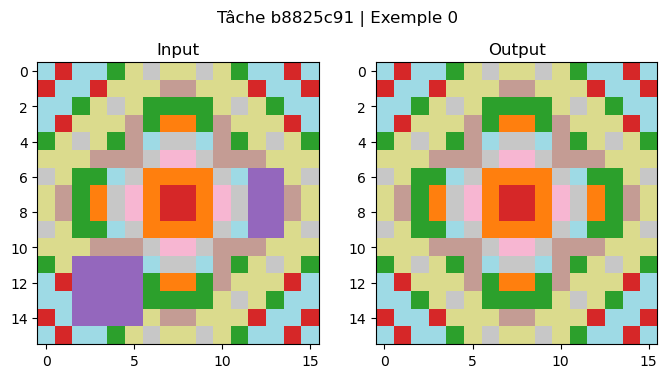

input_shape                    : (16, 16)
output_shape                   : (16, 16)
input_colors                   : [1, 2, 3, 4, 5, 6, 7, 8, 9]
output_colors                  : [1, 2, 3, 5, 6, 7, 8, 9]
recoloration                   : True
rotation_90                    : False
rotation_180                   : False
rotation_270                   : False
flip_horizontal                : False
flip_vertical                  : False
transpose                      : False
repetition                     : False
padding                        : False
translation                    : False
tiled_subgrid                  : False
partial_symetry                : None
pattern_checkerboard           : False
pattern_horizontal_stripes     : False
pattern_vertical_stripes       : False
pattern_uniform_blocks         : False
shape_based_recoloration       : True

=== Analyse des transformations pour la t√¢che b91ae062 ===


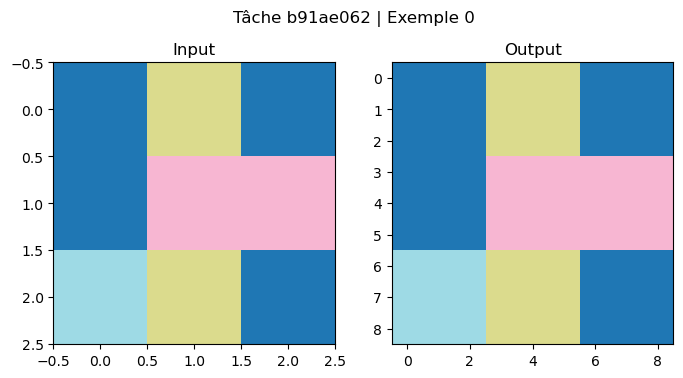

input_shape                    : (3, 3)
output_shape                   : (9, 9)
input_colors                   : [0, 6, 8, 9]
output_colors                  : [0, 6, 8, 9]
recoloration                   : False
rotation_90                    : False
rotation_180                   : False
rotation_270                   : False
flip_horizontal                : False
flip_vertical                  : False
transpose                      : False
repetition                     : False
padding                        : False
translation                    : False
tiled_subgrid                  : False
partial_symetry                : None
pattern_checkerboard           : False
pattern_horizontal_stripes     : False
pattern_vertical_stripes       : False
pattern_uniform_blocks         : False
shape_based_recoloration       : False

=== Analyse des transformations pour la t√¢che f8b3ba0a ===


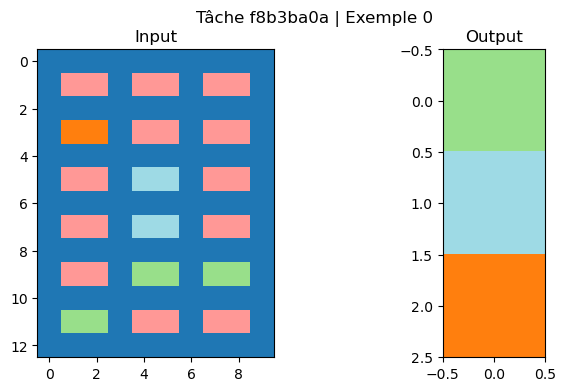

input_shape                    : (13, 10)
output_shape                   : (3, 1)
input_colors                   : [0, 1, 2, 3, 8]
output_colors                  : [1, 2, 8]
recoloration                   : True
rotation_90                    : False
rotation_180                   : False
rotation_270                   : False
flip_horizontal                : False
flip_vertical                  : False
transpose                      : False
repetition                     : False
padding                        : False
translation                    : False
tiled_subgrid                  : False
partial_symetry                : None
pattern_checkerboard           : False
pattern_horizontal_stripes     : False
pattern_vertical_stripes       : False
pattern_uniform_blocks         : False
shape_based_recoloration       : False

=== Analyse des transformations pour la t√¢che ce22a75a ===


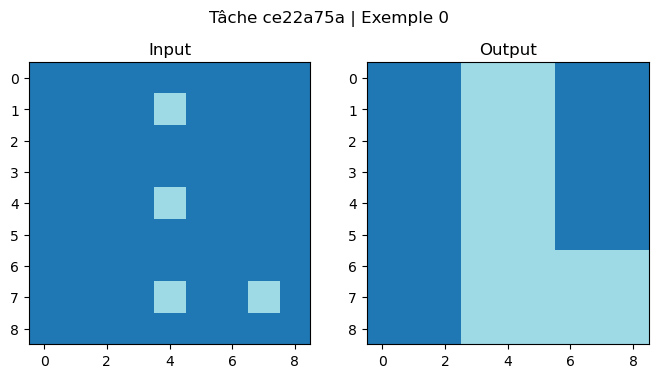

input_shape                    : (9, 9)
output_shape                   : (9, 9)
input_colors                   : [0, 5]
output_colors                  : [0, 1]
recoloration                   : True
rotation_90                    : False
rotation_180                   : False
rotation_270                   : False
flip_horizontal                : False
flip_vertical                  : False
transpose                      : False
repetition                     : False
padding                        : False
translation                    : False
tiled_subgrid                  : False
partial_symetry                : None
pattern_checkerboard           : False
pattern_horizontal_stripes     : False
pattern_vertical_stripes       : False
pattern_uniform_blocks         : False
shape_based_recoloration       : False


In [23]:
run_batch_tests(TASKS_TO_TEST)

In [41]:
sys.path.append('..')

from analysis.spatial_analysis import detect_spatial_changes

In [42]:
with open('../data/arc-agi_training_challenges.json', 'r') as f:
    training_data = json.load(f)

def plot_input_output(input_grid, output_grid, title="Comparaison"):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(input_grid, cmap='tab20', interpolation='nearest')
    axs[0].set_title('Input')
    axs[0].axis('off')

    axs[1].imshow(output_grid, cmap='tab20', interpolation='nearest')
    axs[1].set_title('Output')
    axs[1].axis('off')

    plt.title(title)
    plt.tight_layout()
    plt.show()

def test_task_spatial_changes(task_id, example_index = 0):
    task = training_data[task_id]["train"][example_index]
    input_grid = task["input"]
    output_grid = task["output"]

    plot_input_output(input_grid, output_grid, title=f"T√¢che {task_id} | Exemple {example_index}")

    spatial_results = detect_spatial_changes(input_grid, output_grid)

    print(f"R√©sultats de l'analyse spatiale pour la t√¢che {task_id}:")
    for k, v in spatial_results.items():
        print(f"{k}: {v}")

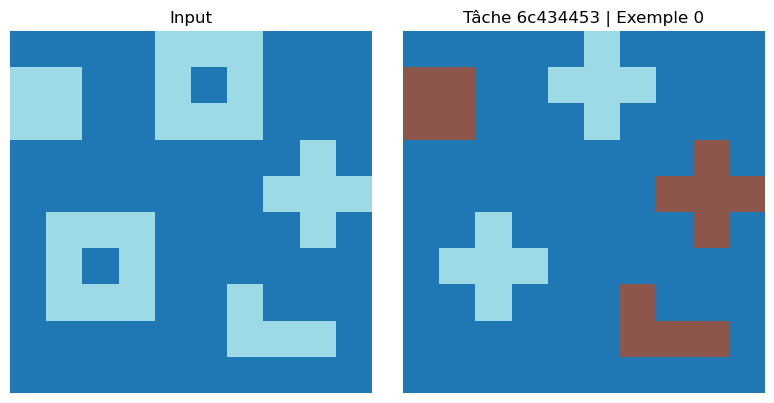

R√©sultats de l'analyse spatiale pour la t√¢che 6c434453:
dilatation_diff_sum: 51
erosion_diff_sum: 22
fill_diff_sum: 8


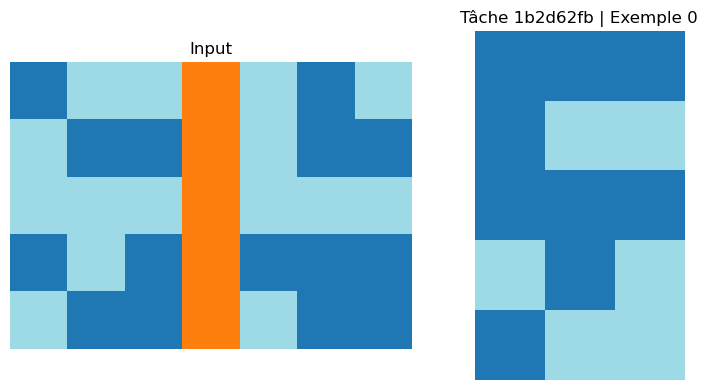

R√©sultats de l'analyse spatiale pour la t√¢che 1b2d62fb:
dilatation_diff_sum: 28
erosion_diff_sum: 7
fill_diff_sum: 24


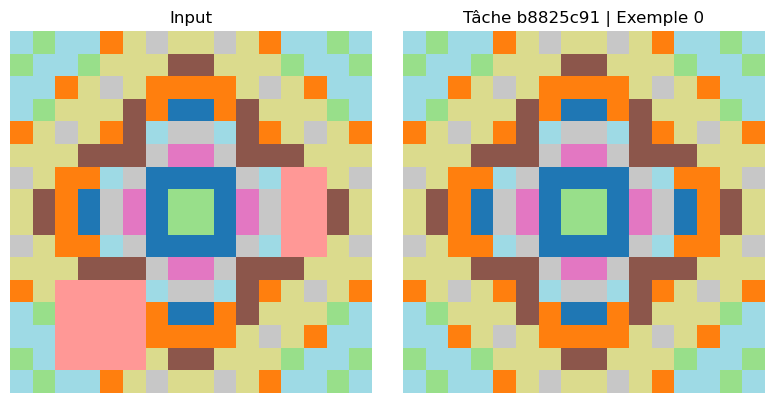

R√©sultats de l'analyse spatiale pour la t√¢che b8825c91:
dilatation_diff_sum: 0
erosion_diff_sum: 60
fill_diff_sum: 0


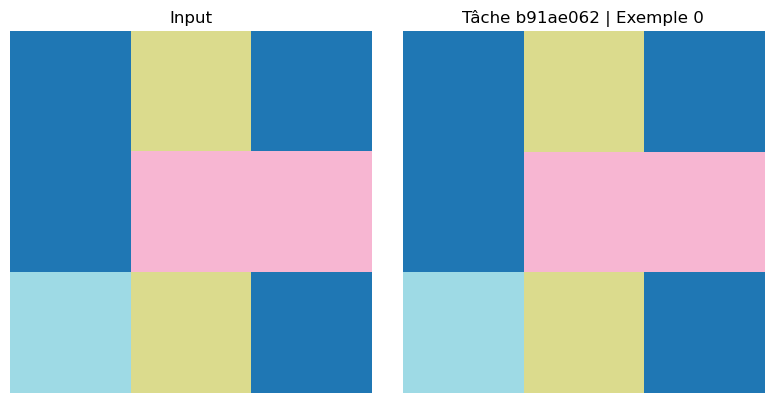

R√©sultats de l'analyse spatiale pour la t√¢che b91ae062:
dilatation_diff_sum: 55
erosion_diff_sum: 45
fill_diff_sum: 50


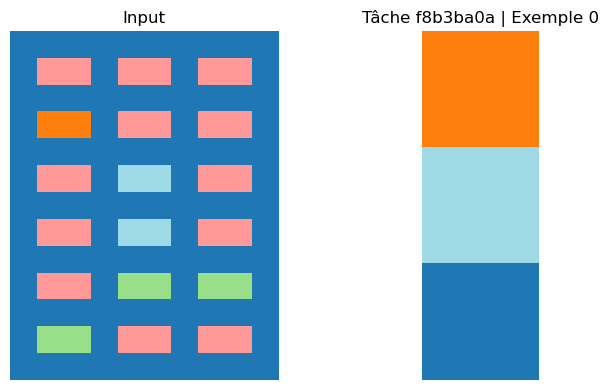

R√©sultats de l'analyse spatiale pour la t√¢che f8b3ba0a:
dilatation_diff_sum: 103
erosion_diff_sum: 3
fill_diff_sum: 39


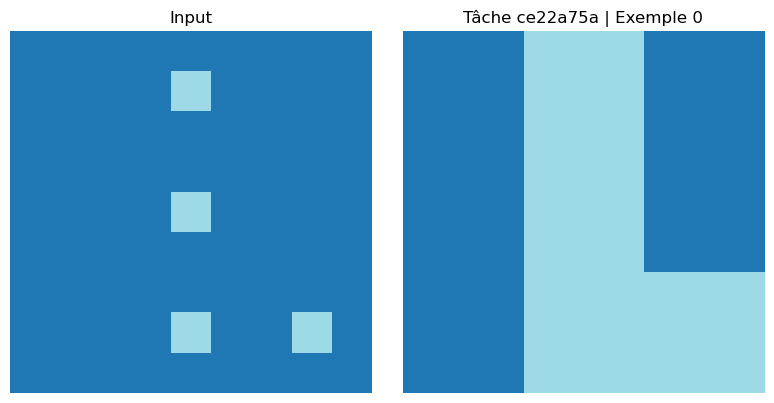

R√©sultats de l'analyse spatiale pour la t√¢che ce22a75a:
dilatation_diff_sum: 16
erosion_diff_sum: 36
fill_diff_sum: 32


In [44]:
import importlib
import analysis.spatial_analysis
importlib.reload(analysis.spatial_analysis)

from analysis.spatial_analysis import detect_spatial_changes

task_ids = ["6c434453", "1b2d62fb", "b8825c91", "b91ae062", "f8b3ba0a", "ce22a75a"]

for task_id in task_ids:
    test_task_spatial_changes(task_id)